# Phân tích dữ liệu YouTube bằng PySpark và trực quan hóa kết quả

Notebook này hướng dẫn phân tích dữ liệu YouTube sử dụng PySpark và trực quan hóa kết quả với matplotlib/pandas.

## 1. Khởi tạo SparkSession và nhập các thư viện cần thiết

Khởi tạo SparkSession và import các thư viện cần thiết như pyspark, matplotlib, pandas.

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("YouTubeTrendAnalysis") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://localstack:4566") \
    .config("spark.hadoop.fs.s3a.access.key", "test") \
    .config("spark.hadoop.fs.s3a.secret.key", "test") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

## 2. Đọc dữ liệu YouTube từ S3 bằng PySpark

Sử dụng Spark để đọc dữ liệu parquet từ S3 và hiển thị một số dòng đầu tiên.

In [ ]:
# Đọc dữ liệu parquet từ S3
df = spark.read.parquet("s3a://youtube-trend-data/transformed/")
df.show(12)

+-----------+---------------------------------+-----------+--------------+-------+------+--------+------+-------------------+--------------------+--------------------+
|         id|                            title|category_id| category_name|  views| likes|comments|region|       published_at|           timestamp|    engagement_ratio|
+-----------+---------------------------------+-----------+--------------+-------+------+--------+------+-------------------+--------------------+--------------------+
|N9ITNp6gqJY|             I Tried the Top 5...|         24| Entertainment|1753683|102527|   15098|    US|2025-06-19 15:00:41|2025-06-20T08:14:...|  0.0584638158663795|
|N9ITNp6gqJY|             I Tried the Top 5...|         24| Entertainment|1762341|102723|   15112|    US|2025-06-19 15:00:41|2025-06-20T08:23:...| 0.05828781149618604|
|TWKvBih3aZ8|             28 Years Later - ...|         24| Entertainment| 387500| 20077|    2348|    US|2025-06-19 13:00:52|2025-06-20T08:14:...| 0.05181161290

## 3. Tiền xử lý dữ liệu danh mục video

Làm sạch và chuẩn hóa tên danh mục video, xử lý các giá trị thiếu hoặc không xác định.

In [ ]:
# 1. Kiểm tra số lượng giá trị null trên từng cột
df.select([F.count(F.when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns]).show()

# 2. Loại bỏ các dòng trùng lặp (nếu có)
df = df.dropDuplicates()

# 3. Loại bỏ các dòng thiếu thông tin quan trọng (ví dụ: thiếu category_id, views, region)
df = df.dropna(subset=["category_id", "views", "region"])

# Kiểm tra lại dữ liệu sau tiền xử lý
df.printSchema()
df.show(5)

In [ ]:

# Làm sạch tên danh mục
category_mapping = df.filter(
    (F.col("category_name").isNotNull()) & 
    (F.col("category_name") != "Unknown")
).select(
    "category_id", 
    F.col("category_name").alias("valid_category_name")
).distinct()

category_filled = df.join(
    category_mapping,
    on="category_id",
    how="left"
).withColumn(
    "category_name_cleaned",
    F.when(
        (F.col("category_name").isNull()) | (F.col("category_name") == "Unknown"),
        F.col("valid_category_name")
    ).otherwise(F.col("category_name"))
).drop("category_name").withColumnRenamed("category_name_cleaned", "category_name")

category_filled.select("category_id", "category_name").distinct().show(truncate=False)

+-----------+--------------------+
|category_id|category_name       |
+-----------+--------------------+
|28         |Science & Technology|
|24         |Entertainment       |
|19         |Travel & Events     |
|1          |Film & Animation    |
|20         |Gaming              |
|25         |News & Politics     |
|10         |Music               |
|27         |Education           |
|23         |Comedy              |
|17         |Sports              |
|22         |People & Blogs      |
|26         |Howto & Style       |
|2          |Autos & Vehicles    |
+-----------+--------------------+



## 4. Gắn tên danh mục cho dữ liệu video

Join bảng dữ liệu video với bảng mapping danh mục để gắn tên danh mục đầy đủ.

In [ ]:
# Tạo bảng mapping thủ công nếu cần
category_mapping_df = spark.createDataFrame([
    (28, "Science & Technology"),
    (24, "Entertainment"),
    (19, "Travel & Events"),
    (1,  "Film & Animation"),
    (20, "Gaming"),
    (25, "News & Politics"),
    (10, "Music"),
    (27, "Education"),
    (23, "Comedy"),
    (17, "Sports"),
    (22, "People & Blogs"),
    (26, "Howto & Style"),
    (15, "Pets & Animals"),
    (2, "Autos & Vehicles")
], ["category_id", "category_name_mapped"])

# Gắn tên danh mục cho dữ liệu video
df = df.join(
    category_mapping_df,
    on="category_id",
    how="left"
).withColumn(
    "category_name",
    when(col("category_name") == "Unknown", col("category_name_mapped"))
    .otherwise(col("category_name"))
).drop("category_name_mapped")

df.select("category_id", "category_name").distinct().show(truncate=False)

+-----------+--------------------+
|category_id|category_name       |
+-----------+--------------------+
|28         |Science & Technology|
|24         |Entertainment       |
|19         |Travel & Events     |
|1          |Film & Animation    |
|20         |Gaming              |
|25         |News & Politics     |
|10         |Music               |
|27         |Education           |
|23         |Comedy              |
|17         |Sports              |
|22         |People & Blogs      |
|26         |Howto & Style       |
|2          |Autos & Vehicles    |
+-----------+--------------------+



## 5. Tạo bảng tạm thời cho truy vấn SQL

Tạo bảng tạm thời (temp view) để có thể truy vấn dữ liệu bằng Spark SQL.

In [12]:
df.createOrReplaceTempView("youtube_trends")

## 6. Thống kê số lượng video theo khu vực

Truy vấn và hiển thị số lượng video theo từng khu vực (region).

In [13]:
count_videos_region = spark.sql("""
    SELECT region, COUNT(*) as video_count
    FROM youtube_trends
    GROUP BY region
""")
count_videos_region.show()

+------+-----------+
|region|video_count|
+------+-----------+
|    KR|        200|
|    US|        200|
|    VN|        100|
+------+-----------+



## 7. Phân tích tỷ lệ tương tác trung bình theo khu vực

Tính toán và sắp xếp tỷ lệ tương tác trung bình (engagement_ratio) theo khu vực.

In [14]:
engagement_by_region = spark.sql("""
    SELECT region, AVG(engagement_ratio) as avg_engagement_ratio
    FROM youtube_trends
    WHERE views > 0
    GROUP BY region
    ORDER BY avg_engagement_ratio DESC
""")
engagement_by_region.show()

+------+--------------------+
|region|avg_engagement_ratio|
+------+--------------------+
|    US| 0.04340593809241132|
|    KR|0.024741199788046737|
|    VN|0.016378124606012824|
+------+--------------------+



## 8. Phân tích top 5 danh mục có lượt xem trung bình cao nhất

Truy vấn và lấy ra 5 danh mục có lượt xem trung bình cao nhất.

In [15]:
top_categories = spark.sql("""
    SELECT category_name, AVG(views) as avg_views
    FROM youtube_trends
    GROUP BY category_name
    ORDER BY avg_views DESC
    LIMIT 5
""")
top_categories.show()

+--------------------+--------------------+
|       category_name|           avg_views|
+--------------------+--------------------+
|    Film & Animation|        1.03954227E7|
|      People & Blogs|1.0069574040983606E7|
|Science & Technology|    8608731.07142857|
|       Entertainment|   6431517.347107438|
|               Music|           5262389.4|
+--------------------+--------------------+



## 9. Trực quan hóa top 5 danh mục theo lượt xem trung bình

Chuyển kết quả sang pandas và vẽ biểu đồ cột thể hiện top 5 danh mục theo lượt xem trung bình.

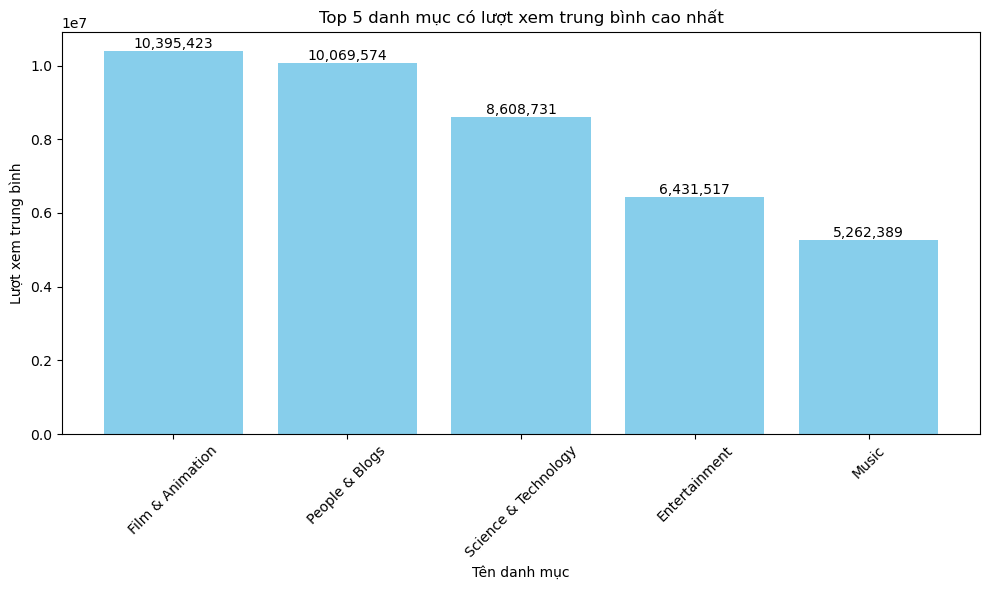

In [16]:
top_categories_pd = top_categories.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_categories_pd['category_name'], top_categories_pd['avg_views'], color='skyblue')
plt.xlabel('Tên danh mục')
plt.ylabel('Lượt xem trung bình')
plt.title('Top 5 danh mục có lượt xem trung bình cao nhất')
plt.xticks(rotation=45)
for i, v in enumerate(top_categories_pd['avg_views']):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

## 10. Phân tích lượt xem trung bình theo danh mục và khu vực

Truy vấn lượt xem trung bình theo từng danh mục và khu vực, sắp xếp theo lượt xem giảm dần.

In [17]:
avg_views = spark.sql("""
    SELECT category_name, region, AVG(views) as avg_views
    FROM youtube_trends
    GROUP BY category_name, region
    ORDER BY avg_views DESC
""")
avg_views.show()

+--------------------+------+--------------------+
|       category_name|region|           avg_views|
+--------------------+------+--------------------+
|Science & Technology|    VN|        5.57243225E7|
|      People & Blogs|    VN| 3.148796739473684E7|
|              Gaming|    VN|         1.9441944E7|
|       Entertainment|    VN|1.8656133515151516E7|
|    Film & Animation|    VN|1.5204141333333334E7|
|               Music|    KR|        7580538.4375|
|               Music|    VN|         7265494.125|
|              Sports|    VN|          3311728.75|
|    Film & Animation|    US|          3182344.75|
|       Entertainment|    KR|  2382328.2321428573|
|               Music|    US|           1942688.0|
|     News & Politics|    US|          1392319.55|
|              Gaming|    US|          1319154.25|
|              Comedy|    KR|        1176740.6875|
|           Education|    US|           1061135.5|
|       Entertainment|    US|          910962.875|
|              Comedy|    US|  

## 11. Trực quan hóa lượt xem trung bình theo danh mục và khu vực

Chuyển kết quả sang pandas và vẽ biểu đồ heatmap thể hiện lượt xem trung bình theo danh mục và khu vực.

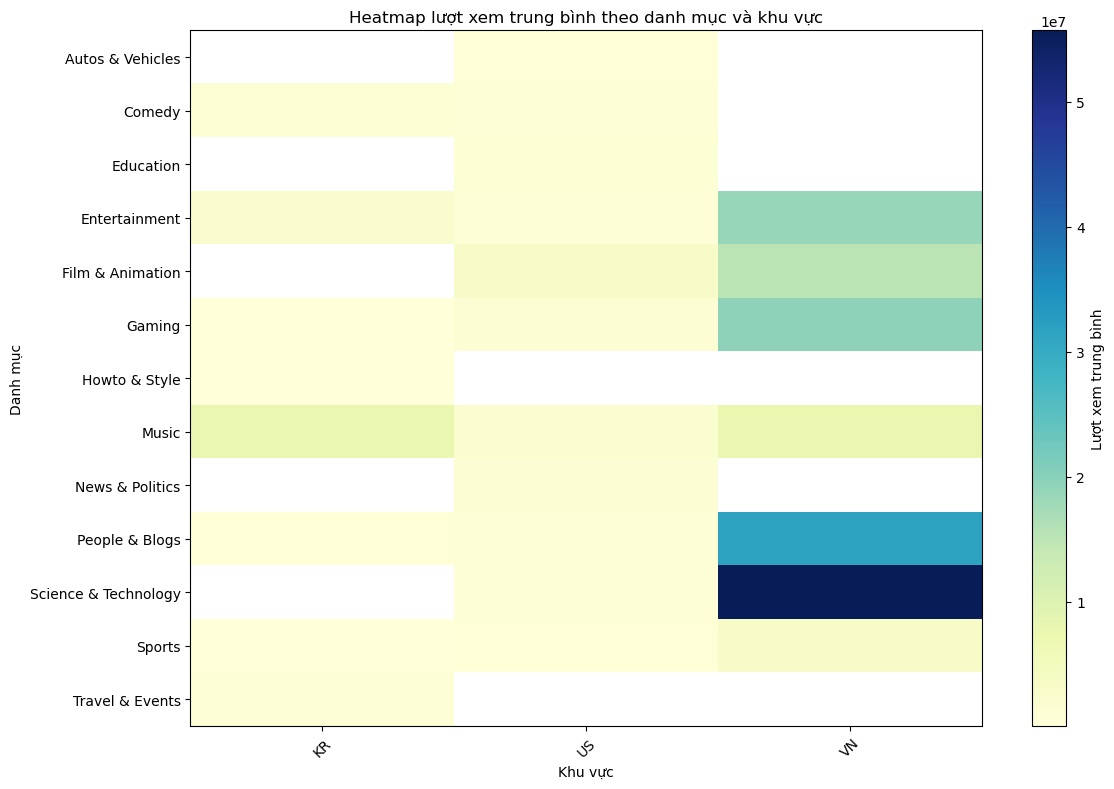

In [18]:
avg_views_pd = avg_views.toPandas()

# Pivot để tạo ma trận cho heatmap
pivot_table = avg_views_pd.pivot(index='category_name', columns='region', values='avg_views')

plt.figure(figsize=(12, 8))
plt.imshow(pivot_table, aspect='auto', cmap='YlGnBu')
plt.colorbar(label='Lượt xem trung bình')
plt.xticks(ticks=range(len(pivot_table.columns)), labels=pivot_table.columns, rotation=45)
plt.yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index)
plt.title('Heatmap lượt xem trung bình theo danh mục và khu vực')
plt.xlabel('Khu vực')
plt.ylabel('Danh mục')
plt.tight_layout()
plt.show()